# Objective 3 : CORRECTION of observation prediction using Data Assimilation

# Setup and Imports
This section imports necessary Python libraries and modules needed for the notebook operations. It sets up the computational environment, ensuring all dependencies are correctly loaded. This includes loading custom modules like `PCA.py` which contain PCA definitions and kalman functions respectively.

## Importing Modules
Here we import necessary Python modules and functions that will be used throughout the notebook. This typically includes libraries like `torch` for machine learning, `numpy` for numerical operations, and `matplotlib` for plotting, as well as modules containing our custom functions and model definitions.

In [2]:
import sys
sys.path.append('..')

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from PCA import resize_images, update_prediction,KalmanGain,perform_pca,KalmanFilter
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from torchvision import transforms
import time

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

## CONVLSTM model 

In [3]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, padding, activation, frame_size):
        super(ConvLSTMCell, self).__init__()

        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'relu':
            self.activation = nn.ReLU()

        self.conv = nn.Conv2d(input_channels + output_channels, 4 * output_channels, kernel_size, padding=padding)
        self.W_ci = nn.Parameter(torch.Tensor(output_channels, *frame_size))
        self.W_co = nn.Parameter(torch.Tensor(output_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.Tensor(output_channels, *frame_size))

    def forward(self, input_tensor, H_prev, C_prev):
        conv_output = self.conv(torch.cat([input_tensor, H_prev], dim=1))
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev)
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev)

        C_out = forget_gate * C_prev + input_gate * self.activation(C_conv)
        output_gate = torch.sigmoid(o_conv + self.W_co * C_out)

        H_out = output_gate * self.activation(C_out)

        return H_out, C_out

class ConvLSTM(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, padding, activation, frame_size):
        super(ConvLSTM, self).__init__()
        self.output_channels = output_channels
        self.conv_lstm_cell = ConvLSTMCell(input_channels, output_channels, kernel_size, padding, activation, frame_size)

    def forward(self, input_tensor):
        batch_size, _, seq_len, height, width = input_tensor.size()

        output = torch.zeros(batch_size, self.output_channels, seq_len, height, width, device=device)
        H = torch.zeros(batch_size, self.output_channels, height, width, device=device)
        C = torch.zeros(batch_size, self.output_channels, height, width, device=device)

        for t in range(seq_len):
            H, C = self.conv_lstm_cell(input_tensor[:, :, t], H, C)
            output[:, :, t] = H

        return output

class ConvLSTMModel(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, padding, activation, frame_size, num_layers):
        super(ConvLSTMModel, self).__init__()

        self.sequential = nn.Sequential()
        self.sequential.add_module('conv_lstm_0', ConvLSTM(input_channels, hidden_channels, kernel_size, padding, activation, frame_size))
        self.sequential.add_module('batch_norm_0', nn.BatchNorm3d(hidden_channels))

        for i in range(1, num_layers):
            self.sequential.add_module(f'conv_lstm_{i}', ConvLSTM(hidden_channels, hidden_channels, kernel_size, padding, activation, frame_size))
            self.sequential.add_module(f'batch_norm_{i}', nn.BatchNorm3d(hidden_channels))

        self.conv = nn.Conv2d(hidden_channels, input_channels, kernel_size, padding=padding)

    def forward(self, x):
        x = self.sequential(x)
        x = self.conv(x[:, :, -1])
        return torch.sigmoid(x)

# Function to load and preprocess images
def load_observation_data(file_path):
    return np.load(file_path)

## Generate 100 images 

In the preliminary phase of our study, the objective is to develop a robust model capable of performing principal component analysis (PCA) prior to the implementation of data assimilation techniques. A notable challenge we face is the limited size of our dataset: the background and observation datasets comprise only five images each. This dataset is insufficient for PCA to effectively capture and represent the underlying principal components due to the constrained variability and breadth of the data.

To address this limitation, we propose to leverage a Convolutional LSTM (ConvLSTM) model, which was successfully developed and validated in a prior task. This model will be employed to augment our dataset by generating synthetic images. Specifically, we will apply a sliding window approach with a size of two, wherein each set of two consecutive images is used to predict a subsequent image. This methodology will enable the generation of an expanded dataset comprising 100 images.

By utilizing this enhanced dataset, PCA can be trained more effectively. This approach allows PCA to assimilate a more comprehensive representation of the data's features, particularly those relevant to the dynamics and characteristics of wildfires. The enhanced learning from a more substantial and representative dataset will underpin more accurate and robust data assimilation in subsequent analyses.

In [4]:
model = ConvLSTMModel(input_channels=1, hidden_channels=16, kernel_size=(3,3), padding=(1,1), activation="relu",
                     frame_size=(128, 128), num_layers=2).to(device)
model_param = torch.load('../model_params_22.pth')
model.load_state_dict(model_param)

observations = np.load('../Ferguson_fire_obs.npy').astype(np.float32) # or background data  

transform = transforms.Compose([    
                transforms.ToPILImage(),
                transforms.Resize((128, 128)),      
                transforms.ToTensor()
            ])      

input_sequences = observations[3:]
input_sequences = torch.stack([transform(input) for input in input_sequences])

# model input shape: (batch_size, channels, seq_len, height, width)
for i in range(298): # 98 steps forecast
    input_sequence = input_sequences[i:i+2] # 2 steps forecast
    input_sequence = torch.stack([transform(input) for input in input_sequence])    
    input_sequence = input_sequence.view(1, 1, 2, 128, 128)
    model.eval()
    with torch.no_grad():
        output_sequence = model(input_sequence.to(device))
    output_sequence = output_sequence.cpu().reshape(1, 128, 128)
    input_sequences = torch.cat((input_sequences, output_sequence.unsqueeze(0)), dim=0)

forecast = input_sequences[2:].detach().numpy() 

In [5]:
forecast.shape

(298, 1, 128, 128)

In [6]:
bk = np.load('../Ferguson_fire_background.npy')
obs = np.load('../Ferguson_fire_obs.npy')

## PCA

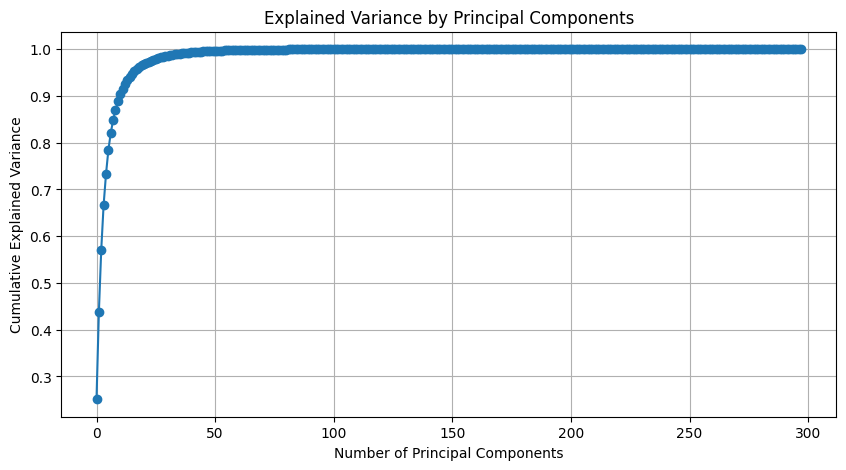

In [7]:
forecast_data = forecast.reshape(forecast.shape[0], -1)
pca = PCA(n_components=min(forecast_data.shape[0], forecast_data.shape[1]))  # You can adjust 'n_components' as needed
pca.fit(forecast_data)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 5))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

Choosing the Variance Threshold (97%)

 By retaining 97% of the variance, I ensure that most of the important information in the data is preserved (36 in 298). The first few principal components capture the most significant patterns in the data, and 97% is a high enough threshold to capture these patterns while reducing dimensionality. Also 97% is a practical balance between reducing the number of features (compression) and minimizing information loss.

Benefits of Setting the Variance to 97%

There are around 300 images generated by using the Convlstm model that are completely not enough for pca to learn the vital imformation for the wildfire. Setting the number of dimensions while retaining 97% of the variance ensures that most of the important information is preserved. 

In [8]:
desired_variance = 0.97
num_components = np.argmax(cumulative_explained_variance >= desired_variance) + 1
print(f"Number of components to retain 99% of the variance: {num_components}")

# Fit PCA again with the selected number of components
pca_optimal = PCA(n_components=num_components)
reduced_forecast_data = pca_optimal.fit_transform(forecast_data)
print(f"Reduced forecast data shape: {reduced_forecast_data.shape}")

Number of components to retain 99% of the variance: 22
Reduced forecast data shape: (298, 22)


In [9]:
obs_resized = resize_images(obs)
bk_resized = resize_images(bk)

# Flatten the observation and background data
obs_flatten = obs_resized.reshape(5, 128*128)
bk_flatten = bk_resized.reshape(5, 128*128)

# Perform PCA on forecast data
pca = PCA(n_components=22)
forecast_reshaped = forecast.reshape(-1, 128*128)
pca.fit(forecast_reshaped)
forecast_pca = pca.transform(forecast_reshaped)

# Transform the observation and background data using the trained PCA
start_time_latent = time.time()
obs_test_latent = pca.transform(obs_flatten)
bk_test_latent = pca.transform(bk_flatten)
end_time_latent = time.time()

# Calculate MSE in reduced space
mse_reduced_test = mean_squared_error(obs_test_latent, bk_test_latent)
print(f'MSE in reduced space (test): {mse_reduced_test}')
print(f'Execution time for transformation to reduced space (test): {end_time_latent - start_time_latent} seconds')

MSE in reduced space (test): 3.3737007708755242
Execution time for transformation to reduced space (test): 0.004804849624633789 seconds


In [10]:
# Start timing for physical space operations
obs_test_reconstructed = pca.inverse_transform(obs_test_latent)
bk_test_reconstructed = pca.inverse_transform(bk_test_latent)

## Kalman filter

In [11]:
# Kalman filter parameters
nNodes = bk_test_latent.shape[1]
I = np.eye(nNodes)
R = 0.1 * I  # Observation noise covariance matrix
H = I  # Observation model matrix
diagonal_variances = np.var(forecast_pca, axis=0)
B = np.diag(diagonal_variances) * 10  # Process noise covariance matrix

# Kalman filter application
start = time.time()
x = np.zeros(nNodes)
updated_states = np.zeros_like(bk_test_latent)
model_data_compr = bk_test_latent
sensors_data_compr = obs_test_latent  # Assuming this is the observed data

for t in range(obs_test_latent.shape[0]):
    x = model_data_compr[t]
    y = sensors_data_compr[t]

    K = KalmanGain(B, H, R)
    x_updated = update_prediction(x, K, H, y)
    updated_states[t] = x_updated

updated_states = np.array(updated_states)

### Setting \( R = 0.1 \)

#### Confidence in Measurement Accuracy:
A smaller \( R \) value, such as 0.1, indicates a high degree of confidence in the accuracy and reliability of the measurements. This setting is suitable when sensors or data acquisition systems are known to be precise and exhibit low noise characteristics. In applications where measurement devices are highly calibrated and minimally affected by environmental noise, a smaller \( R \) enables the Kalman filter to place greater reliance on the observations than on the model forecasts.

#### Stability and Responsiveness:
A lower \( R \) makes the filter more responsive to changes in the observed data, allowing it to quickly adjust to discrepancies between model predictions and actual measurements. This responsiveness is particularly beneficial in dynamic environments where rapid adaptation to real-world changes is critical.

#### Reduced Risk of Overfitting:
By maintaining reasonable trust in the measurements (not excessively low), the filter avoids overfitting to observation noise. This balance is crucial for maintaining the generalizability and robustness of the filter's performance.

### Setting \( B = 10 \)

#### Model Uncertainty and External Disturbances:
A higher \( B \) value suggests that the process model may not perfectly capture the dynamics of the system, potentially due to modeling simplifications or unknown external influences. In scenarios where the system is complex or subjected to frequent external disturbances not accounted for by the model, a larger \( B \) aids in accommodating these uncertainties, thereby preventing the filter from being overly reliant on potentially inaccurate or incomplete model dynamics.

#### Flexibility in State Estimation:
Setting \( B \) higher allows the filter the flexibility to deviate from the model predictions if the incoming observations significantly differ from what the model forecasts. This flexibility is essential in adaptive systems where conditions change unpredictably.

#### Balance in Dynamic Systems:
For highly dynamic systems, such as those in robotics, weather forecasting, or financial markets, where rapid changes are commonplace, a larger \( B \) ensures that the Kalman filter can quickly adapt to new developments that the static model parameters cannot predict.


In [12]:
obs_test_reconstructed = pca.inverse_transform(obs_test_latent)
bk_test_reconstructed = pca.inverse_transform(bk_test_latent)

# Reconstruct images from PCA components before and after assimilation
reconstructed_forecast_images = pca.inverse_transform(forecast_pca).reshape(-1, 128, 128)
reconstructed_assimilated_images = pca.inverse_transform(updated_states).reshape(-1, 128, 128)

# Clip the final after assimilation forecast result
reconstructed_assimilated_images_clipped = np.clip(reconstructed_assimilated_images, 0, 255)

In [13]:
# Calculate MSE in latent and physical spaces for the final image
obs_image = obs_resized[-1].reshape(1, -1)
forecast_image = forecast[-1].reshape(1, -1)

# Apply PCA to the observation and forecast image
pca_obs = pca.transform(obs_image)
pca_forecast_image = pca.transform(forecast_image)

# Get the corresponding assimilated image
pca_assimilated_image = updated_states[-1].reshape(1, -1)

# Calculate MSE in latent space
mse_latent_before = mean_squared_error(pca_obs, updated_states[-2].reshape(1, -1))
mse_latent_after = mean_squared_error(pca_obs, pca_assimilated_image)

# Reconstruct images from PCA components
reconstructed_forecast_image = pca.inverse_transform(pca_forecast_image).reshape(128, 128)
reconstructed_assimilated_image = pca.inverse_transform(pca_assimilated_image).reshape(128, 128)

# Clip the final after assimilation forecast result
reconstructed_assimilated_image_clipped = np.clip(reconstructed_assimilated_image, 0, 255)

# Calculate MSE in physical space
mse_physical_before = mean_squared_error(obs_resized[-1].reshape(-1), reconstructed_forecast_image.reshape(-1))
mse_physical_after = mean_squared_error(obs_resized[-1].reshape(-1), reconstructed_assimilated_image_clipped.reshape(-1))

In [14]:
print(f'Final Image:')
print(f'MSE in latent space before assimilation: {mse_latent_before}')
print(f'MSE in latent space after assimilation: {mse_latent_after}')
print(f'MSE in physical space before assimilation: {mse_physical_before}')
print(f'MSE in physical space after assimilation: {mse_physical_after}')

Final Image:
MSE in latent space before assimilation: 0.05233516374063027
MSE in latent space after assimilation: 0.00034548406581429354
MSE in physical space before assimilation: 0.36589211225509644
MSE in physical space after assimilation: 0.012757991257849675


Text(0.5, 1.0, 'After Assimilation')

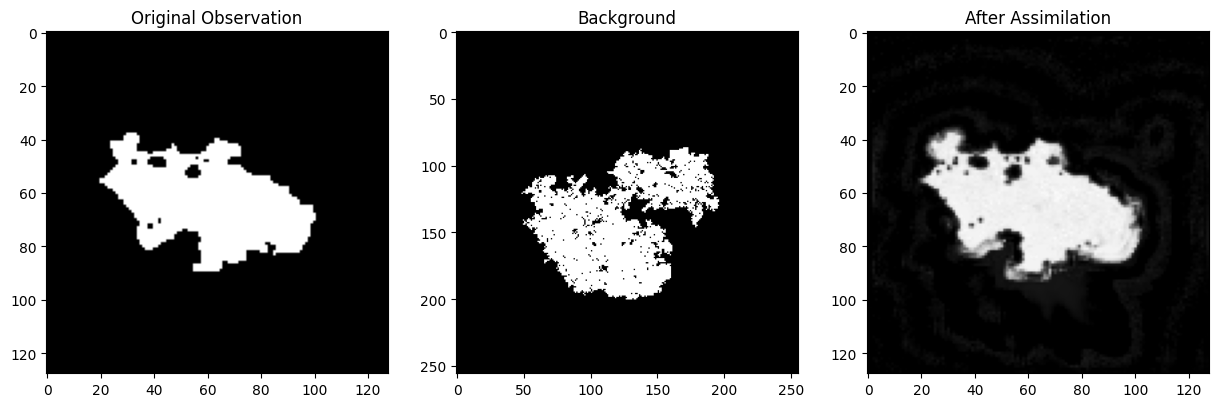

In [15]:
# Plot the final image before and after assimilation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(obs_resized[-1], cmap='gray')
axes[0].set_title('Original Observation')
axes[1].imshow(bk[-1], cmap='gray')
axes[1].set_title('Background')
axes[2].imshow(reconstructed_assimilated_images_clipped[-1], cmap='gray')
axes[2].set_title('After Assimilation')

# Summary 

Overfitting in PCA
1. Model Complexity Relative to Data Variability

PCA is generally considered a non-parametric method, meaning it doesn't inherently overfit because it doesn't involve predictive modeling. However, in practice, PCA can lead to what might be seen as an "overfitting-like" scenario, particularly when the model complexity (in terms of the number of principal components retained) does not align well with the intrinsic variability in the data.

In typical use, overfitting in PCA can occur if the number of principal components used is too high relative to the amount of training data or if the data variability is low. Overfitting, in this sense, means capturing too much noise as if it were signal, which can occur when the principal components begin to represent the idiosyncrasies of the training data rather than any underlying pattern applicable to more general cases.

2. Limited Data Variance

If your dataset primarily consists of images that are highly similar (such as being generated solely from two very similar images), the variance captured by PCA is inherently skewed towards the characteristics of these images. When PCA is trained in such an environment, the components it identifies are overly specific to these images and may not generalize well to other data. This situation effectively simulates overfitting because the components are too finely tuned to the specifics of the limited input data.

3. Slice Window Methodology

The use of a slicing window, especially a narrow one like two, for model predictions can enhance the risk of overfitting in PCA. This methodological choice means that the PCA model is potentially being fitted and validated on data slices that are highly correlated. When sequential images (like the fourth and fifth in a series) are very similar due to the slice window setup, the PCA might overly adapt to these similarities.

The implications of this are twofold:

Temporal Autocorrelation: In time-series data or sequentially correlated images, consecutive samples (slices) are not independent. PCA, assuming independent data points, can misinterpret autocorrelation as significant variance, leading to biased principal components that do not effectively represent the underlying data structure.
Generalizability: A PCA model trained in such a narrowly defined context may perform well within that specific scenario (e.g., predicting the fifth image based on the fourth) but poorly when presented with more varied or less correlated data.
4. Data Homogeneity from Limited Sources

Using images derived from just two observation points (images no.4 and no.5) to generate the entire training dataset significantly reduces the heterogeneity of the dataset. This limitation in the diversity of the training examples means that the PCA will likely capture nuances specific to these images at the expense of losing the broader applicability. As such, the model's ability to generalize from such a training regimen is severely compromised, mimicking an overfitting scenario where the model's utility is confined to its training set and performs poorly on unseen data.

Conclusion
To mitigate these issues, consider the following strategies:

Expand the Data Set: Include a wider variety of images from different conditions and time points to increase the dataset's diversity and representativeness.
Increase Slice Window: Use a larger slice window to reduce the temporal correlation between consecutive images, helping to ensure that the PCA captures more general patterns rather than overfitting to specific sequential similarities.
Component Number Optimization: Carefully determine the number of principal components to retain by considering the explained variance ratio and potentially employing techniques like cross-validation.

## VAE

### Loading Datas

In [98]:
model_path = "../datas/Ferguson_fire_background.npy"
sensors_path = "../datas/Ferguson_fire_obs.npy"

In [99]:
from other.objective0 import DataPreparation, WildFireDataset
from torch.utils.data import DataLoader

DataPreparator = DataPreparation(train_path="../datas/Ferguson_fire_train.npy", test_path="../datas/Ferguson_fire_test.npy", dtype="float32")
wildfires_training_set, wildfires_testing_set = DataPreparator.train, DataPreparator.test

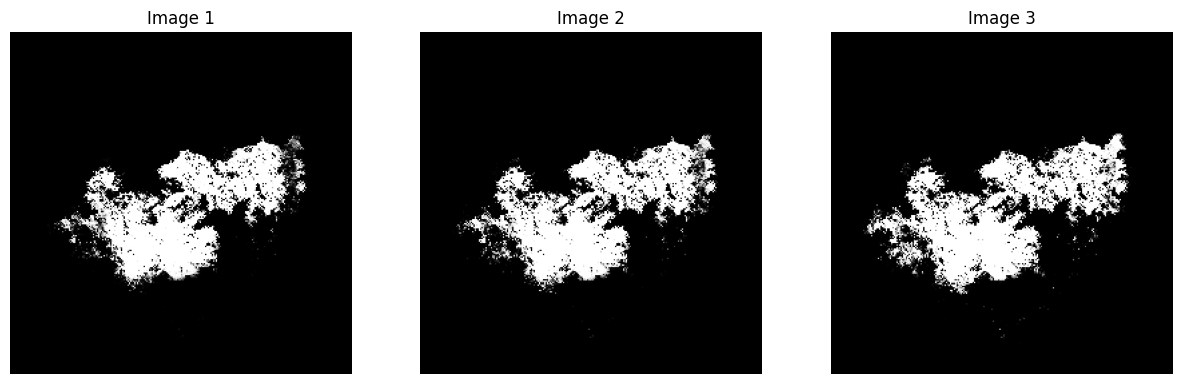

In [16]:
# Load the images from the .npy file
images = np.load('../objective2_da_images.npy')

# Ensure that the images array contains three images and adjust for singleton dimensions
if images.shape[0] == 3:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figsize to better fit your notebook
    titles = ['Image 1', 'Image 2', 'Image 3']
    for i, ax in enumerate(axes):
        # Remove singleton dimensions with np.squeeze before displaying
        ax.imshow(np.squeeze(images[i]), cmap='gray')  # Assuming the images are in grayscale
        ax.set_title(titles[i])
        ax.axis('off')  # Hide axes ticks
    plt.show()

## Data Assimilation with linear compression (PCA) with a surrogate model for predictions

### Overview of the Method

In this part, we will take a slightly different approach to data assimilation. We aim to implement an assimilation problem using the method described in [this paper](https://www.sciencedirect.com/science/article/pii/S0021999122003643#se0030). The process is as follows:

1. **Train a Compression Algorithm**: We will first train a compression algorithm, called φ, to convert data from the physical space to the compressed space.
2. **Predict and Assimilate**: Ideally, we would train a predictive model to forecast the next wildfire images in the compressed space based on previous ones. These predictions would then be assimilated with observed data to improve accuracy, continuing this cycle to predict subsequent images.
3. **Current Approach**: In this notebook, we will demonstrate that this method increases measurement precision. However, instead of predicting the next image in the compressed space, we will predict it in the physical space and then compress it for assimilation.

### Forecasting model

In [100]:
from vae import VAE
import torch 

state_dict = torch.load("../models/vae_state_assessment.pth", map_location=torch.device('cpu'))
vae = VAE('cpu', 65536, [1024, 512], 32, activation="GELU")
vae.load_state_dict(state_dict);
vae

VAE(
  (activate): GELU(approximate='none')
  (fc1): Linear(in_features=65536, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc41): Linear(in_features=512, out_features=32, bias=True)
  (fc42): Linear(in_features=512, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=512, bias=True)
  (fc7): Linear(in_features=512, out_features=1024, bias=True)
  (fc8): Linear(in_features=1024, out_features=65536, bias=True)
)

### Recuded Order Modelling

In [101]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

pca = TruncatedSVD(n_components=100)

from scipy.sparse import csr_matrix
pca.fit(csr_matrix(wildfires_training_set.reshape(wildfires_training_set.shape[0], -1)))

observation_path = "../datas/Ferguson_fire_obs.npy"
observation_data = np.load(observation_path).astype(np.float32)
observation_data_hat = pca.transform(csr_matrix(observation_data.reshape(-1, 65536)))

print (f"Observation data shape after compression is {observation_data_hat.shape}")

Observation data shape after compression is (5, 100)


### Algorithm Implementation

We got inspired by the algo in [the paper](https://www.sciencedirect.com/science/article/pii/S0021999122003643#se0030) to code our dynamic assimilation !

1. Number of time-steps: $t_F$
2. LSTM input length: $n_{\text{input}}$
3. LSTM output length: $n_{\text{output}}$

**Inputs:**

4. Initial states: $u_i$, for $i \in \{0..t_x\}$
   
5. Observation data: $y_i$, for $i \in T_y$
   
6. Estimated latent covariance matrices: $\hat{B}$, $\hat{R}$
   
7. Latent observation operator: $\hat{H}$
   
8. Trained LSTM function $f^L$

**Algorithm:**

9. Projection/encoding $\phi$:
    - $u_i \rightarrow x^b_i$, for $i \in \{0..t_x\}$
    - $y_i \rightarrow \hat{y}_i$, for $i \in T_y$
    
    $i \leftarrow t_x$

10. While $i < t_F$: 
    do
    - $\{x^b_{i+1}, x^b_{i+2}, ..., x^b_{i+n_{\text{output}}}\} = f^L(x^b_{i-n_{\text{input}}}, x^b_{i-n_{\text{input}}+1}, ..., x^b_i)$
    - For $j$ from $i + 1$ to $i + n_{\text{output}}$ do
        - If $j \in T_y$ then
            - $(\hat{B}, \hat{R}) \leftarrow DI01(x^b_j, \hat{y}_j, \hat{B}, \hat{R}, \hat{H})$
            - $x^a_j \leftarrow DA(x^b_j, \hat{y}_j, \hat{B}, \hat{R}, \hat{H})$
            - $x^b_j \leftarrow x^a_j$
        - End
    - End
    - $i \leftarrow i + n_{\text{input}}$
    - End

**Outputs:**
- $\{x^b_i, i \in \{0..t_F\}\}$

In our scenario, the initial state will only consist of the first image from the observed data, as we utilize a single-length sequence to forecast the subsequent image and repeat the process iteratively.

### Error covariance tuning functions

In [102]:
import numpy as np
import time
from numpy.linalg import inv

def Jb(xa, xb, B):
    return np.dot(np.dot(np.transpose(xa - xb), np.linalg.pinv(B)), (xa - xb))

def Jr(y, H, R, xa):
    return np.dot(np.dot(np.transpose(y - np.dot(H, xa)), np.linalg.pinv(R)), (y - np.dot(H, xa)))

def KalmanGain(B, H, R):
    return np.dot(B, np.dot(H.T, np.linalg.inv(np.dot(H, np.dot(B, H.T)) + R)))

def DI01(xb, y, H, B, R):
    K = KalmanGain(B, H, R)
    xa = xb + np.dot(K, (y - np.dot(H, xb)))
    Jr(y, H, R, xa)
    sb = 2 * Jb(xa, xb, B) / np.trace(np.dot(K, H))
    sr = 2 * Jr(y, H, R, xa) / np.trace(np.eye(B.shape[0]) - np.dot(H, K))
    return sb * B, sr * R

### Data Assimilation Process

In [135]:
def DA(xb, y, H, B, R):
    K = KalmanGain(B, H, R)
    xa = xb + np.dot((y - np.dot(xb,H)), K)
    return xa

def data_assimilation(phi, f, DA, observation_data, B_hat, R_hat, H_hat, tF):
    y_hat = np.array([phi(obs) for obs in observation_data])
    xa = []
    xb = []
    for j in range(0, len(y_hat)-1):
        pred = f([observation_data[j]])
        xb.append(pred)
        pred = phi(pred)
        B_hat, R_hat = DI01(pred.T, y_hat[j+1].T, H_hat, B_hat, R_hat) 
        pred = DA(pred, y_hat[j], B_hat, R_hat, H_hat)
        xa.append(pred)
    return xa, xb

### Execution

We will try the combination of Compression, VAE predictor, DA and DI01 to our application of wildfire forecasting

Since the observed and background data occupy the same location, we employ the identity matrix for H, eliminating the necessity for mapping or interpolating results.

Initially, we opt to utilize the identity matrix for B_hat and R_hat since the observed and background data are situated in the same position

In [147]:
B_hat = np.eye(100)
R_hat = np.eye(100)
H_hat = np.eye(100)

from sklearn.metrics import mean_squared_error as mse

def phi_pca(state):
    return pca.transform(state.reshape(-1, 65536))

def f_vae(elem):
    reconstructed_x, mean, log_var = vae(torch.as_tensor(elem[0].reshape(-1, 65536)))
    return reconstructed_x.detach().numpy()

xa, xb = data_assimilation(phi=phi_pca, f=f_vae, DA=DA, observation_data = observation_data, B_hat=B_hat, R_hat=R_hat, H_hat=H_hat, tF=3)

xa = np.array(xa).reshape(-1, 100)
xb = np.array(xb).reshape(-1, 65536)

xa_reconstructed = pca.inverse_transform(xa)

print(f"Result after DA: {mse(observation_data[1:].reshape(-1, 65536), xa_reconstructed)}")
print()
print(f"Result before DA: {mse(observation_data[1:].reshape(-1, 65536), xb)}")


Result after DA:0.10648860984636989

Result before DA:0.09065944701433182


Subsequently, we implement R as the covariance matrix of observations in the reduced space.

In [149]:
B_hat = np.eye(100)

def covariance_matrix(X):
    means = np.array([np.mean(X, axis=1)]).transpose()
    dev_matrix = X - means
    res = np.dot(dev_matrix, dev_matrix.transpose()) / (X.shape[1] - 1)
    return res

R_hat = covariance_matrix(observation_data_hat.T)

H_hat = np.eye(100)

from sklearn.metrics import mean_squared_error as mse

def phi_pca(state):
    return pca.transform(state.reshape(-1, 65536))

def f_vae(elem):
    reconstructed_x, mean, log_var = vae(torch.as_tensor(elem[0].reshape(-1, 65536)))
    return reconstructed_x.detach().numpy()

xa, xb = data_assimilation(phi=phi_pca, f=f_vae, DA=DA, observation_data = observation_data, B_hat=B_hat, R_hat=R_hat, H_hat=H_hat, tF=3)

xa = np.array(xa).reshape(-1, 100)
xb = np.array(xb).reshape(-1, 65536)

xa_reconstructed = pca.inverse_transform(xa)

print(f"Result after DA: {mse(observation_data[1:].reshape(-1, 65536), xa_reconstructed)}")
print()
print(f"Result before DA: {mse(observation_data[1:].reshape(-1, 65536), xb)}")

Result after DA: 0.10220979695696294

Result before DA: 0.09054465591907501


We've noticed that implementing this method hasn't significantly improved our results. This could be attributed to the fact that the data assimilation process operates on a window that isn't large enough to capture the dynamics effectively.